<a href="https://colab.research.google.com/github/kanishquetyagi/Company-Bankruptcy-Prediction/blob/main/COMPANY_BANKRUPTCY_PREDICTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

import pandas as pd
import numpy as np
df=pd.read_csv('/content/drive/MyDrive/AlmaBetter/Module 4 - ML/Week 1/Datasets/COMPANY BANKRUPTCY PREDICTION.csv')

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
pd.options.display.float_format = '{:,.6f}'.format
from imblearn.ensemble import BalancedBaggingClassifier
import warnings
warnings.filterwarnings("ignore")
from sklearn.naive_bayes import GaussianNB
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.linear_model import Lasso
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported fro

In [6]:
#creating a for loop to get the categorical columns with 2 or less than 2 unique values
list_1=[]
for i in df.columns:
  x=df[i].value_counts()
  if len(x)<=15:
    list_1.append(i)
  else:
    continue
list_1

['Bankrupt?', ' Liability-Assets Flag', ' Net Income Flag']

In [7]:
df.drop(columns=[' Net Income Flag', ' Liability-Assets Flag'],inplace=True)


In [8]:
df.shape

(6819, 94)

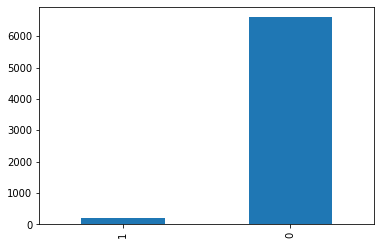

In [9]:
df['Bankrupt?'].value_counts().sort_values().plot(kind = 'bar')


In [11]:
df['Bankrupt?'].value_counts()

0    6599
1     220
Name: Bankrupt?, dtype: int64

#1. Feature Selection.¶


In [13]:
#1.VIF

y=df['Bankrupt?']
X_1=df.drop(columns='Bankrupt?')

In [14]:
X_1_transformed=X_1.copy()
X_1.shape

(6819, 93)

In [53]:
empty_=0
vif_data = pd.DataFrame()
cols_removed_vif=[]
columns_after_vif=[x for x in X_1_transformed.columns]
#Using a while loop to keep removing a feature with VIF value greater 15 one at a time.
while empty_ ==0:
 
  # VIF dataframe
  vif_data = pd.DataFrame()
  vif_data["feature"] = columns_after_vif
  vif_data["VIF"] = [variance_inflation_factor(X_1_transformed[columns_after_vif].values, i)
                              for i in range(len(columns_after_vif))]  
  # calculating VIF for each feature
  if np.array(vif_data.sort_values('VIF')['VIF'])[-1:]>=15:
    cols_removed_vif.extend([x for x in vif_data.sort_values('VIF')['feature'][-1:] if x not in cols_removed_vif])
    columns_after_vif=[x for x in X_1_transformed.columns if x not in cols_removed_vif]                          
    empty_=0
  else:
    empty_=2



In [22]:
# creating a df with these columns.
vif_final=X_1[[x for x in X_1.columns if x not in cols_removed_vif]]

SyntaxError: ignored

In [19]:
vif_final.shape

(6819, 71)

In [20]:
from sklearn.preprocessing import PowerTransformer
# Transforming the highly skewed data
skewness=PowerTransformer(standardize=True)
vif_final_transformed=pd.DataFrame(skewness.fit_transform(vif_final), columns=vif_final.columns)

In [21]:

#running the generalized linear model with logit  function to check the p-values
vif_final_GLM=vif_final_transformed.copy()
vif_final_GLM.set_axis(['x'+str(i) for i in range(0,len(vif_final.columns))], axis='columns', inplace=True)
formula = " Bankrupt ~ "+ '+'.join(vif_final_GLM.columns)
vif_final_GLM['Bankrupt']=y

In [23]:

#fitting the model
model = sm.GLM.from_formula(formula, family=sm.families.Binomial(), data=vif_final_GLM)
result = model.fit()
#result.summary()

In [24]:
#removing the columns with p_value less than 0.05
p_val=pd.DataFrame(zip(vif_final_transformed.columns,result.pvalues[1:]),columns=['column','p_values'])
columns_based_on_p_and_vif=[x for x in p_val[p_val.p_values<=0.05]['column']]
len(columns_based_on_p_and_vif)

14

In [25]:
##. with L1 regularization
# transforming the data to remove skewness
skewness=PowerTransformer(standardize=False)
vif_final=pd.DataFrame(skewness.fit_transform(vif_final), columns=vif_final.columns)

In [26]:
#splitting the data into train and test
X_train, X_test, y_train, y_test=train_test_split(vif_final,y,test_size=0.25,stratify=y, random_state=43)

In [27]:

#scaling the data 
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [28]:

# fitting the logistic regression model
lr=LogisticRegression(penalty='l1',solver='saga',class_weight='balanced',C=0.01)
lr.fit(X_train,y_train)
y_train_pred=lr.predict(X_train)
y_test_pred=lr.predict(X_test)
print(confusion_matrix(y_train,y_train_pred))
print(classification_report(y_train,y_train_pred))
print(confusion_matrix(y_test,y_test_pred))
print(classification_report(y_test,y_test_pred))

[[4210  739]
 [  17  148]]
              precision    recall  f1-score   support

           0       1.00      0.85      0.92      4949
           1       0.17      0.90      0.28       165

    accuracy                           0.85      5114
   macro avg       0.58      0.87      0.60      5114
weighted avg       0.97      0.85      0.90      5114

[[1404  246]
 [   3   52]]
              precision    recall  f1-score   support

           0       1.00      0.85      0.92      1650
           1       0.17      0.95      0.29        55

    accuracy                           0.85      1705
   macro avg       0.59      0.90      0.61      1705
weighted avg       0.97      0.85      0.90      1705



In [29]:

#creating a data frame of the coefficients and column names
coef_df=pd.DataFrame(zip(vif_final.columns,lr.coef_.reshape(-1,1)),columns=['column','coeff'])
#storing the columns with non zero coefficients
columns_after_vif_l1=[x for x in coef_df[coef_df.coeff!=0]['column']]
len(columns_after_vif_l1)

19

In [30]:
##PValue with OLS


#scaling the data
scaler=StandardScaler()
X_2=scaler.fit_transform(X_1)

In [32]:

model = sm.OLS(y, X_2)
results = model.fit()
#print(results.summary())

In [33]:
p_val_ols=pd.DataFrame(zip(X_1.columns,results.pvalues),columns=['column','p_values'])
columns_based_on_p_values_ols=[x for x in p_val_ols[p_val_ols.p_values<=0.05]['column']]
len(columns_based_on_p_values_ols)

32

In [35]:
#information gain

# create importances dataframe
from sklearn.feature_selection import mutual_info_classif

importances = mutual_info_classif(X_1,y)
importances_df = pd.concat([pd.DataFrame(X_1.columns),pd.DataFrame(importances)],axis=1)
importances_df.columns = ['Features','Importances']
importances_df = importances_df.sort_values(by='Importances',ascending=False)
# Top 30 important features
new_features = importances_df.head(30)

In [36]:
feature_list = new_features.Features.tolist()
feature_list

[' Persistent EPS in the Last Four Seasons',
 " Net Income to Stockholder's Equity",
 ' Borrowing dependency',
 ' Net profit before tax/Paid-in capital',
 ' Per Share Net profit before tax (Yuan ¥)',
 ' Net Income to Total Assets',
 ' ROA(A) before interest and % after tax',
 ' Net worth/Assets',
 ' Interest Expense Ratio',
 ' Continuous interest rate (after tax)',
 ' Debt ratio %',
 ' Equity to Liability',
 ' Total debt/Total net worth',
 ' Interest Coverage Ratio (Interest expense to EBIT)',
 ' Liability to Equity',
 ' Retained Earnings to Total Assets',
 ' Degree of Financial Leverage (DFL)',
 ' ROA(C) before interest and depreciation before interest',
 ' Net Value Per Share (A)',
 ' Total income/Total expense',
 ' ROA(B) before interest and depreciation after tax',
 ' Pre-tax net Interest Rate',
 ' Net Value Per Share (B)',
 ' Net Value Per Share (C)',
 ' After-tax net Interest Rate',
 ' Non-industry income and expenditure/revenue',
 ' Current Liabilities/Equity',
 ' Current Liabil

In [38]:
##QUASI
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold=0.01)
sel.fit(X_1)

sum(sel.get_support())

print(
    len([
        i for i in X_1.columns
        if i not in X_1.columns[sel.get_support()]
    ]))

[i for i in X_1.columns if i not in X_1.columns[sel.get_support()]]

segregated_list = [i for i in X_1.columns if i in X_1.columns[sel.get_support()]]
len(segregated_list)

62


31

Feature selection </br>
Random forest compared with information gain(TOP 30 features)

In [39]:
rf = RandomForestClassifier(n_estimators=200,criterion='gini',class_weight='balanced',random_state= 21,n_jobs=-1)

In [40]:
rf.fit(X_1,y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=21, verbose=0,
                       warm_start=False)

In [41]:
imp_df = pd.DataFrame(rf.feature_importances_)
imp_df.shape

(93, 1)

In [42]:
feature_imp_df = pd.concat([pd.DataFrame(X_1.columns),imp_df],axis=1)
feature_imp_df.columns=['features','imp']
feature_imp_df = feature_imp_df.sort_values(by='imp',ascending=False)
feature_imp_df = feature_imp_df.head(30)

In [43]:
feature_list2 = feature_imp_df.features.tolist()


In [44]:

# Function to check number similarity of two lists
def list_similarity(l1,l2):
  '''This function return the number of common elements between two given lists 
  and a list of those common elements '''
  list_bool = []
  for elem1 in l1:
    for elem2 in l2: 
      if elem1==elem2:
        list_bool.append(True)
  print('No of commom elements= ',sum(list_bool))
  return list(set(l1).intersection(set(l2)))

In [45]:

# Check feature similarity between two feature lists obtained above
similar_list = list_similarity(feature_list,feature_list2)

No of commom elements=  27


In [47]:
## Correlation
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = df.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

corr_features = correlation(x, 0.8)
print('correlated features: ', len(set(corr_features)) )

lista = list(corr_features)
lista.append('Bankrupt?')

set(corr_features)
len(corr_features)

correlated features:  25


25

#EDA

In [49]:
df2 = df.iloc[:,1:].copy()
X = df2
Y = df['Bankrupt?']

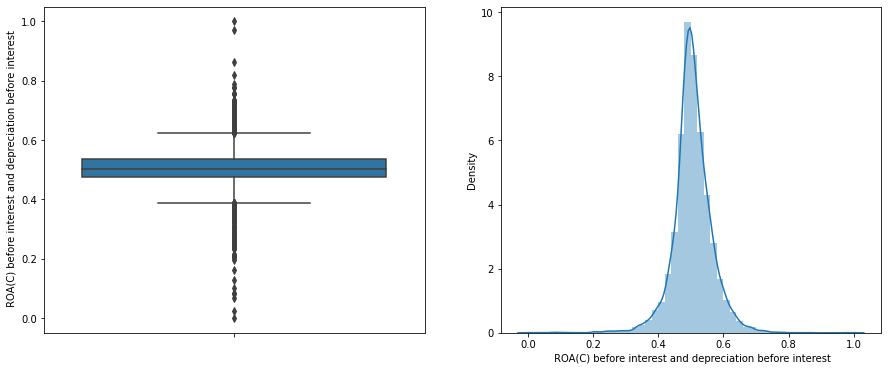

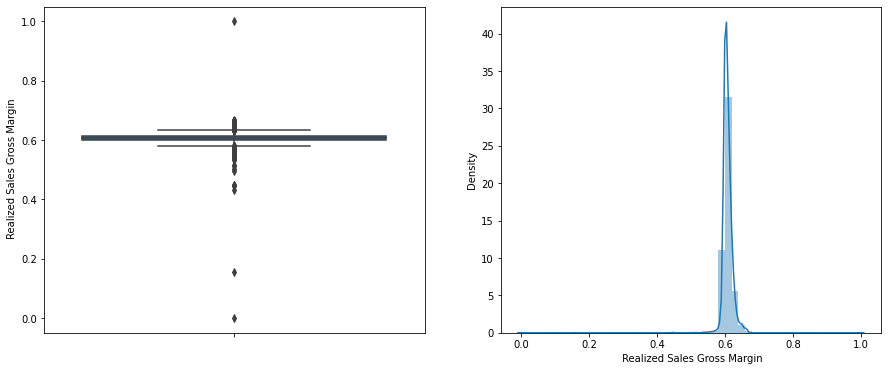

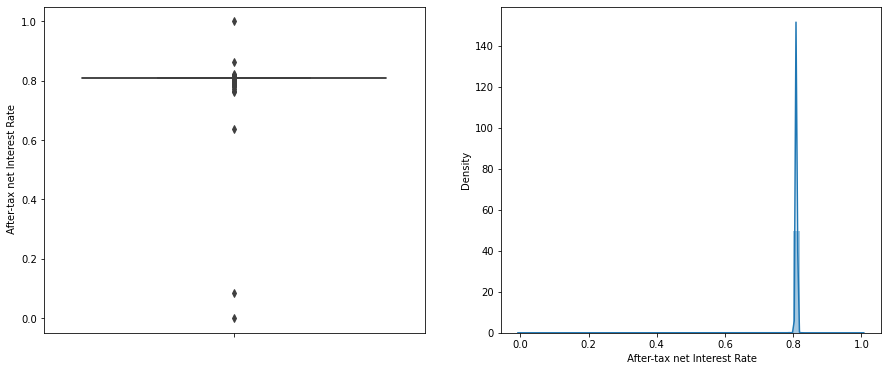

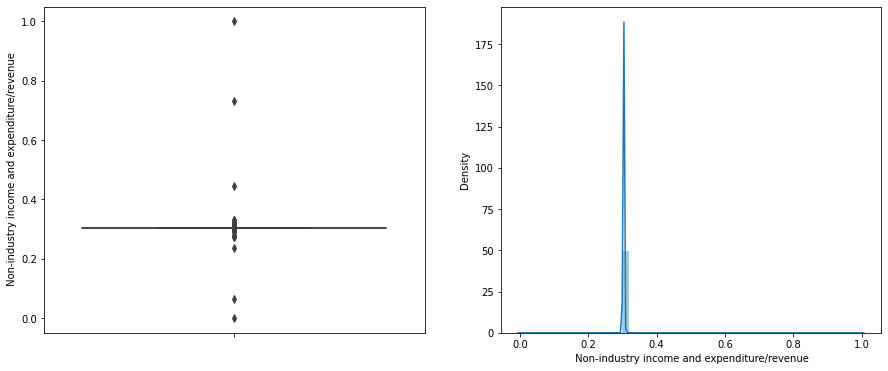

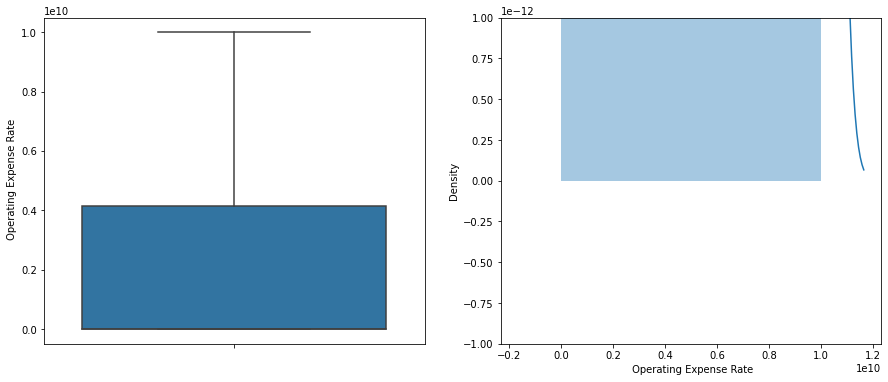

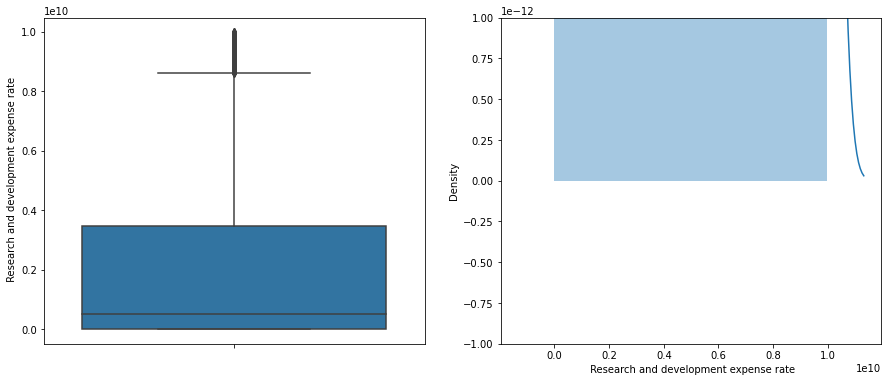

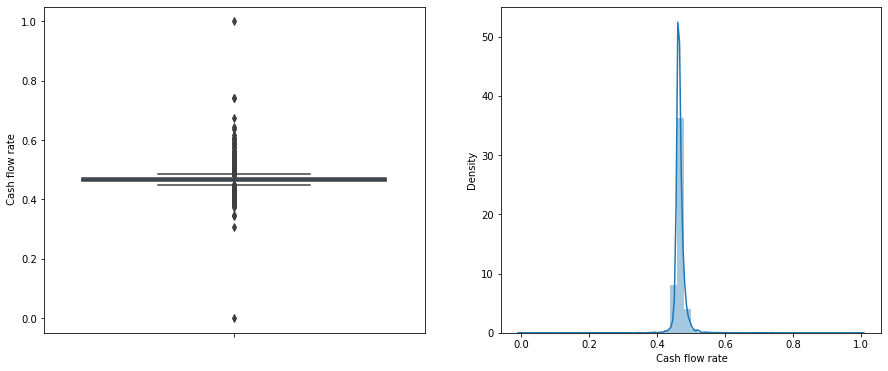

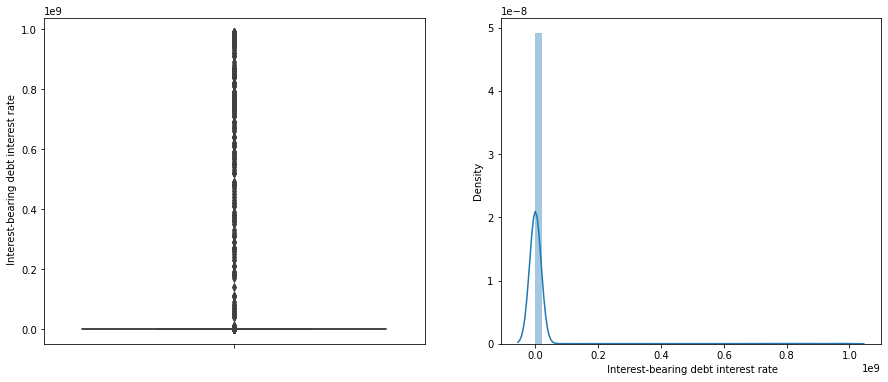

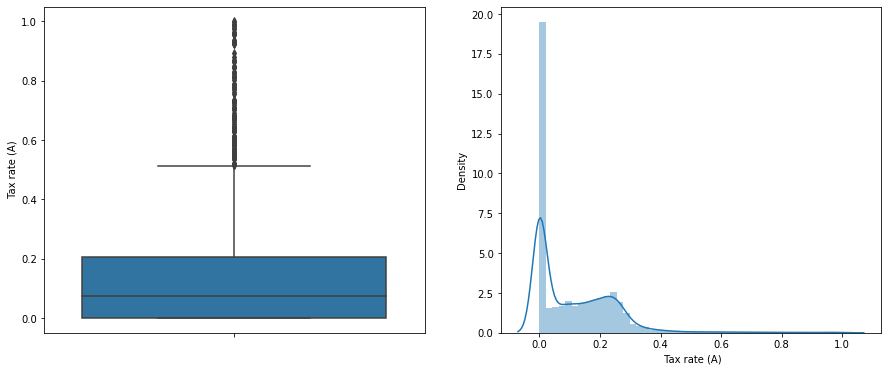

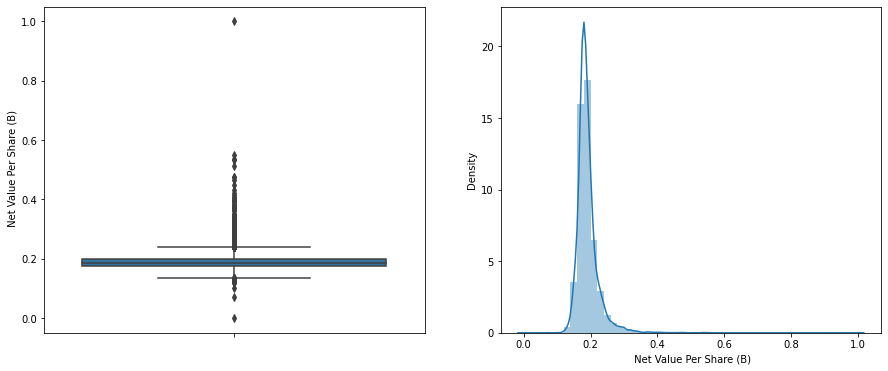

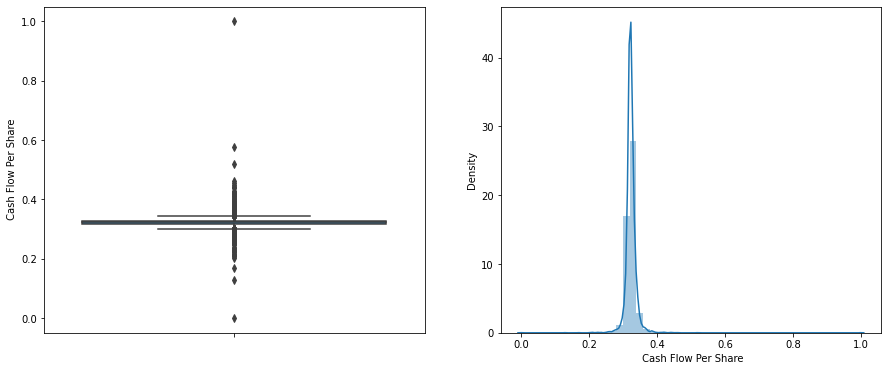

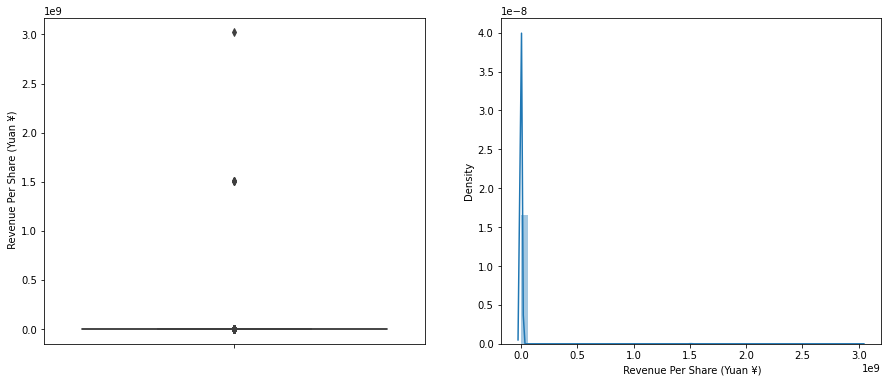

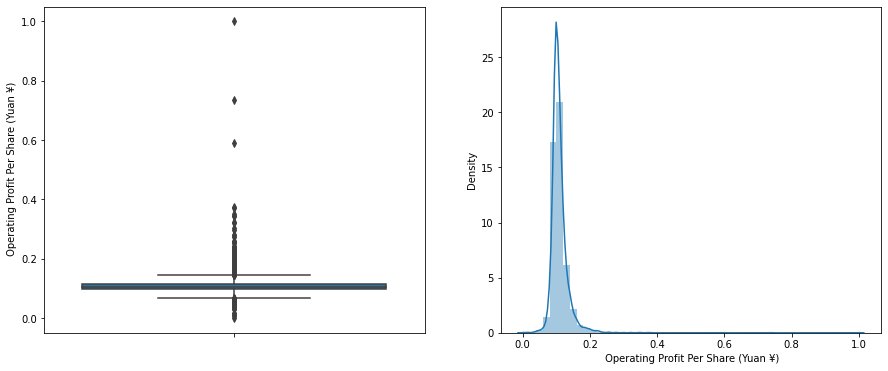

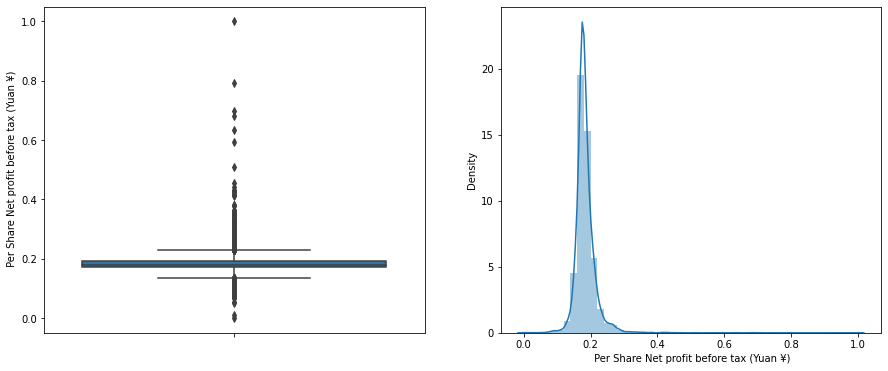

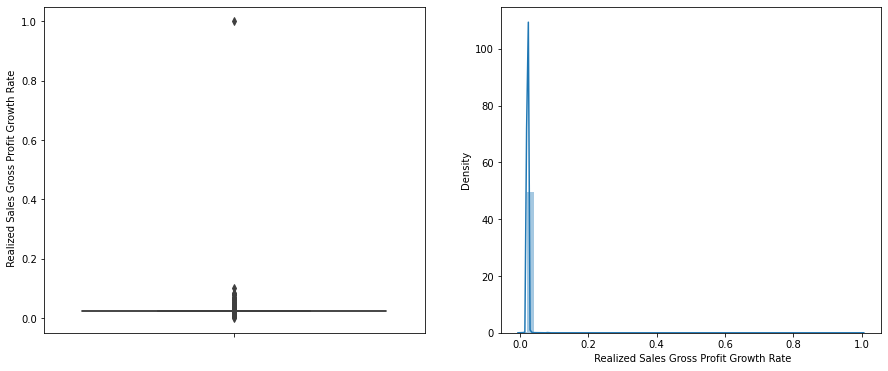

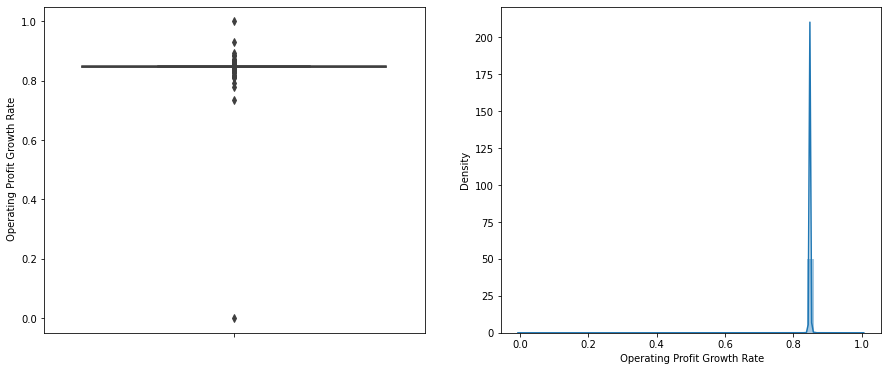

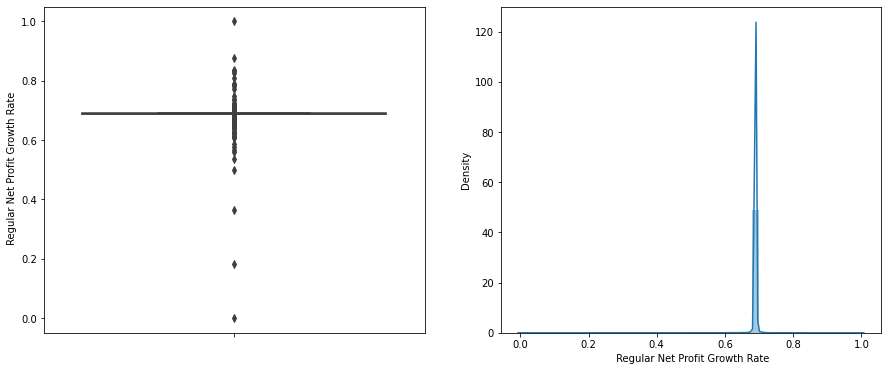

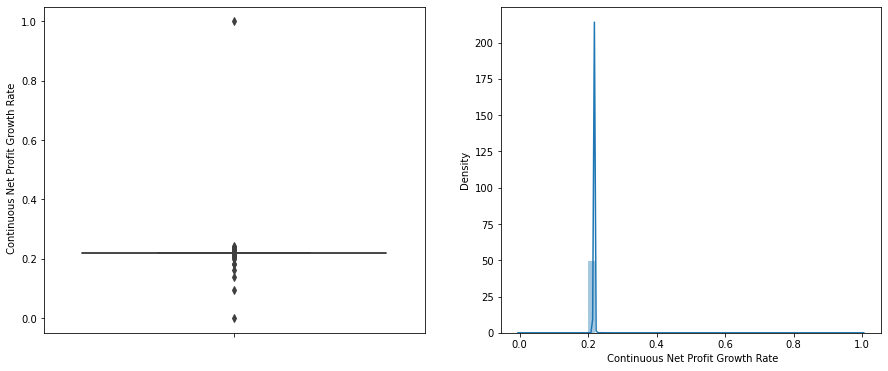

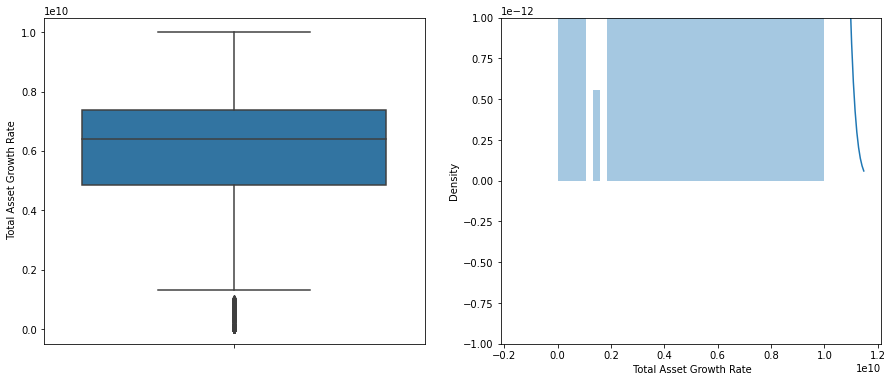

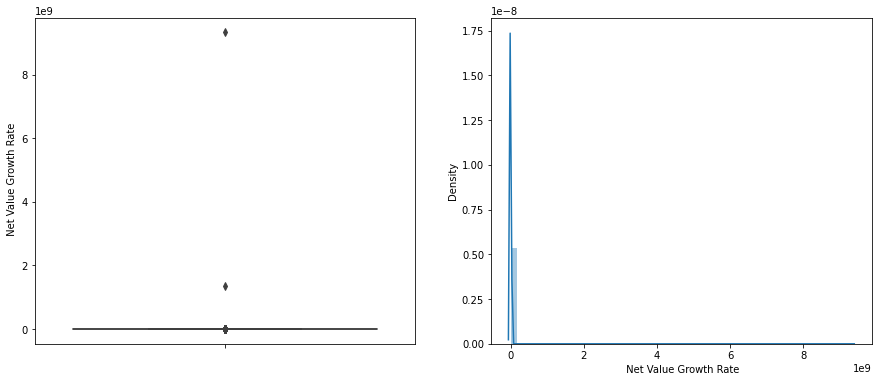

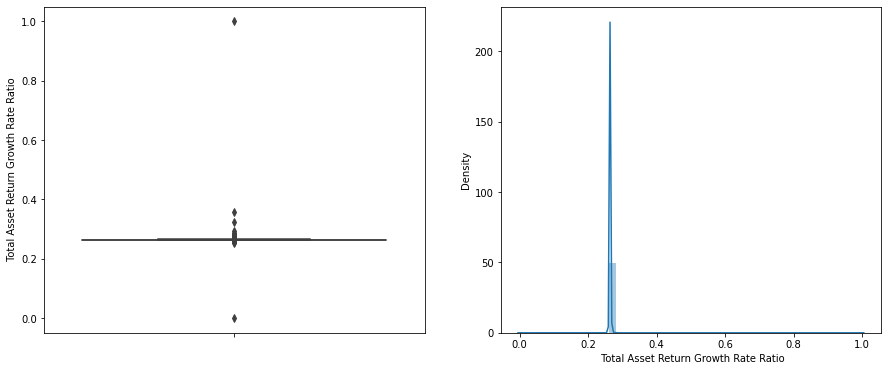

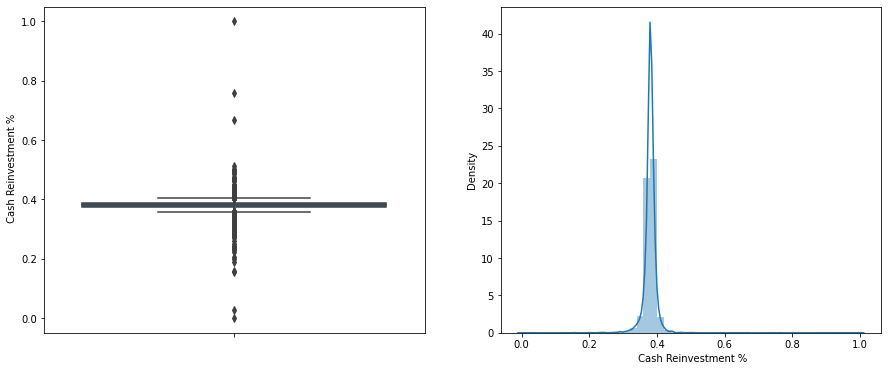

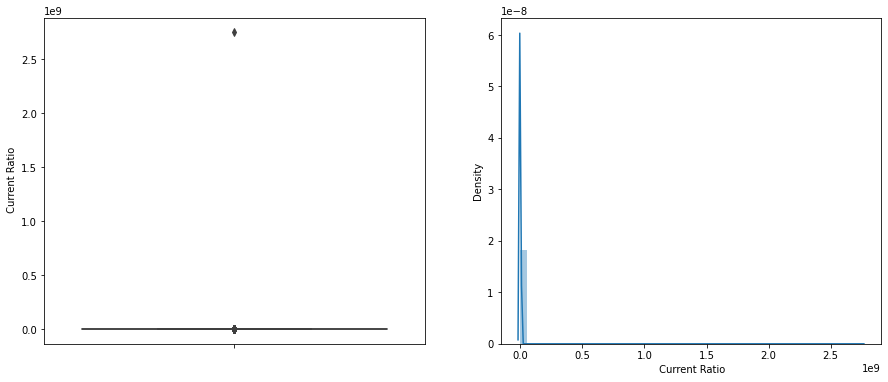

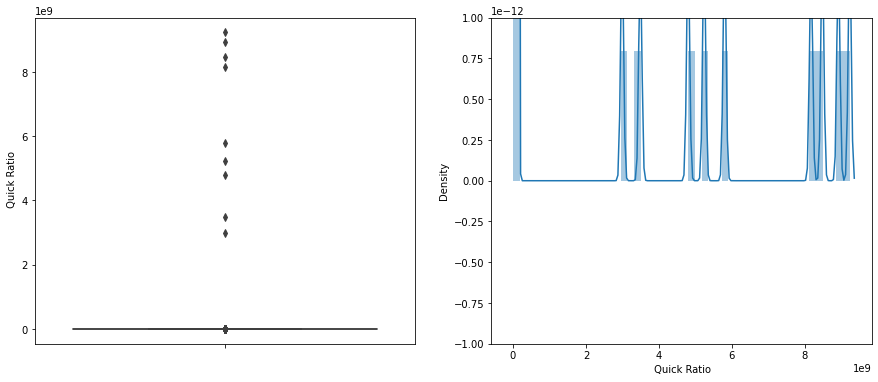

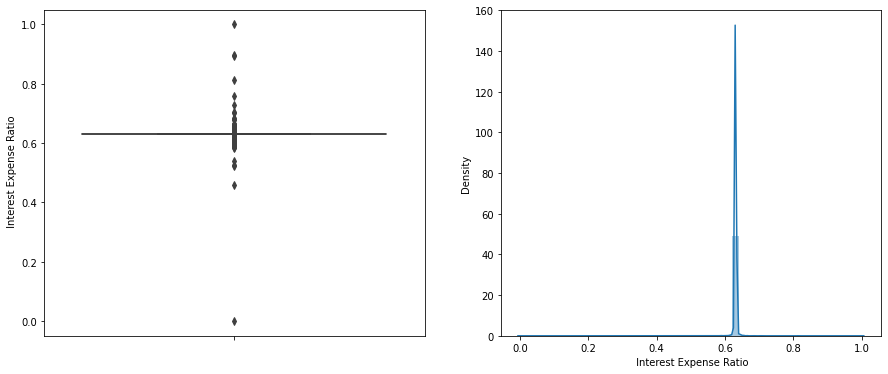

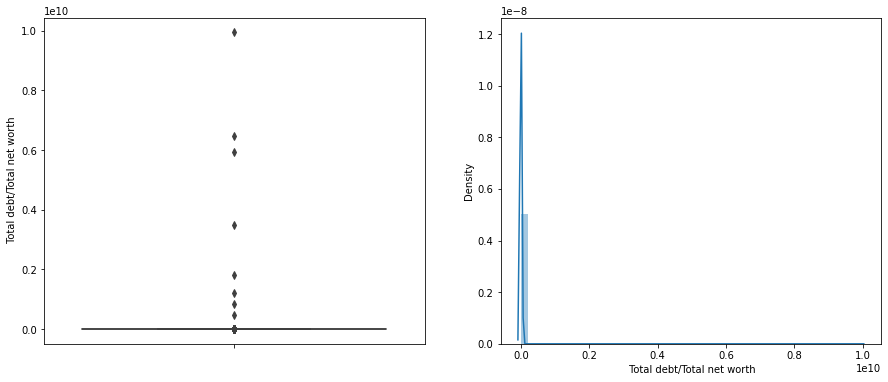

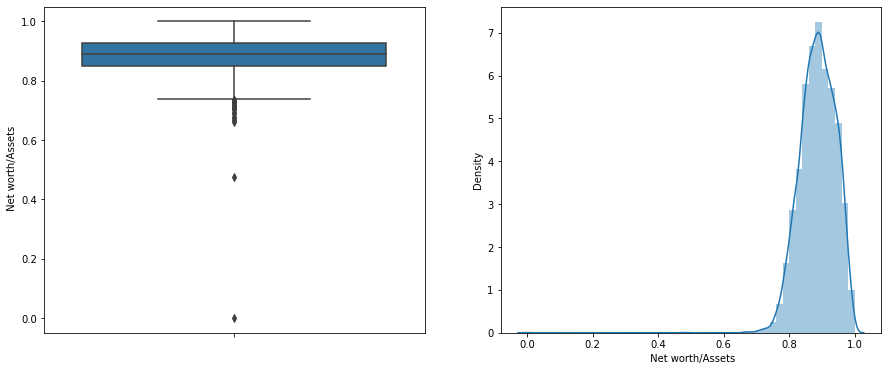

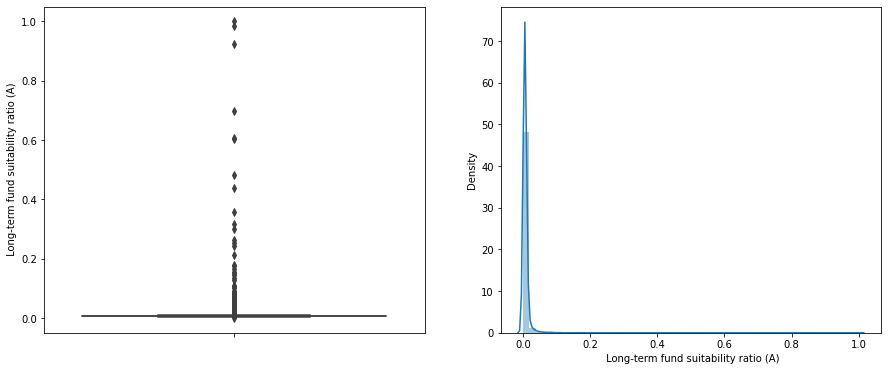

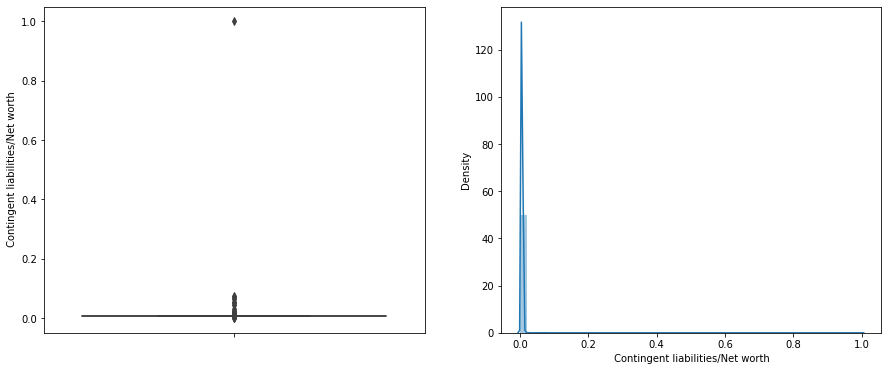

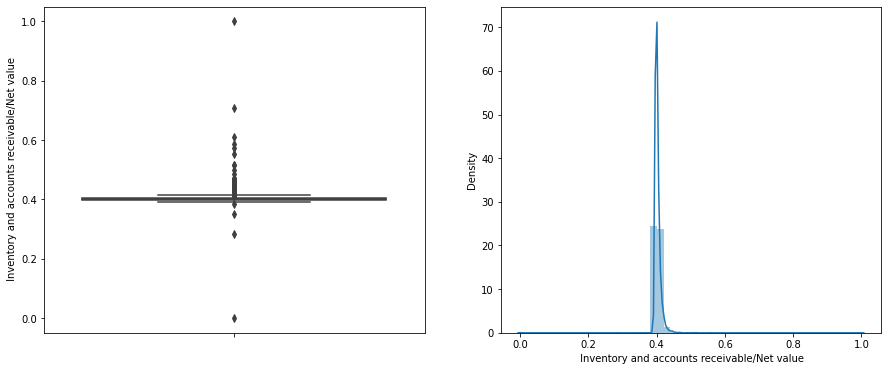

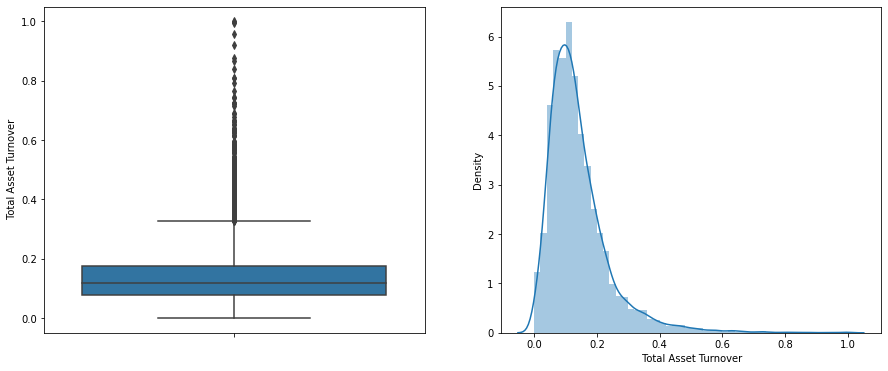

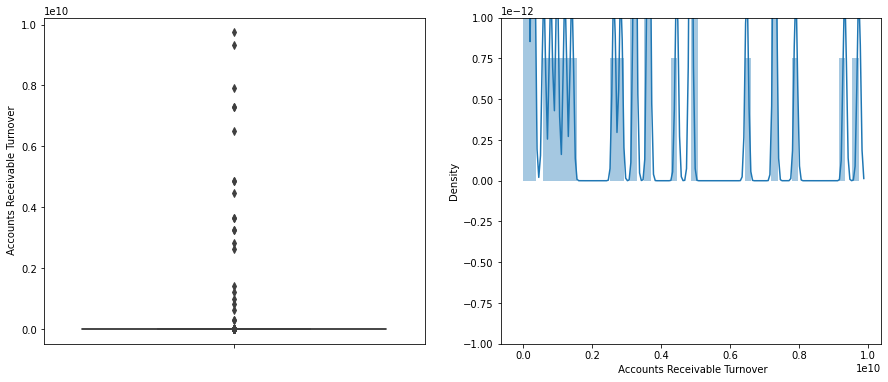

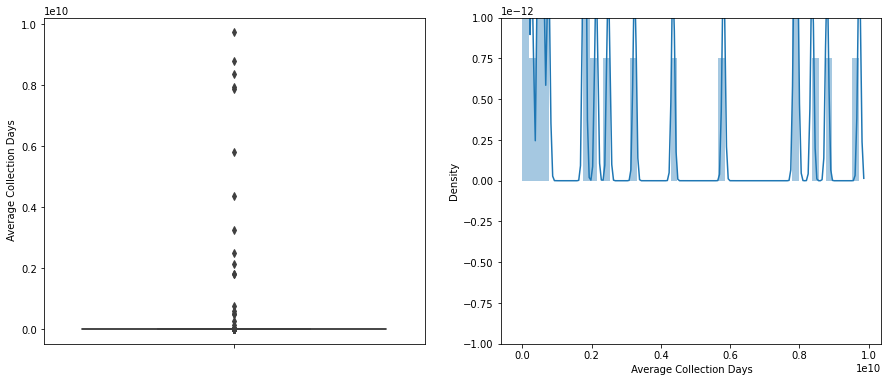

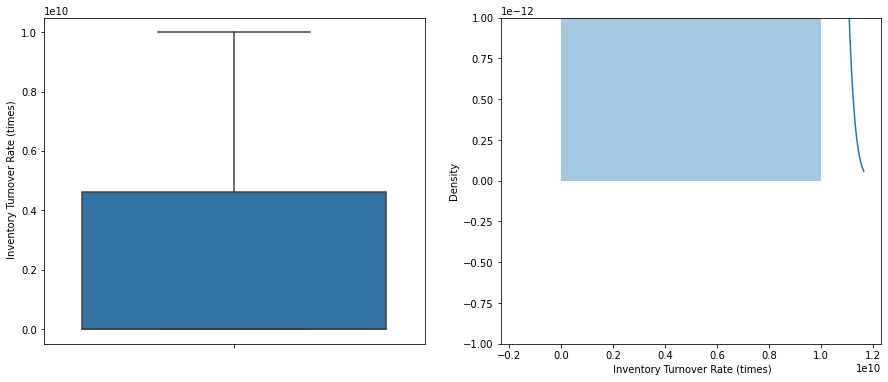

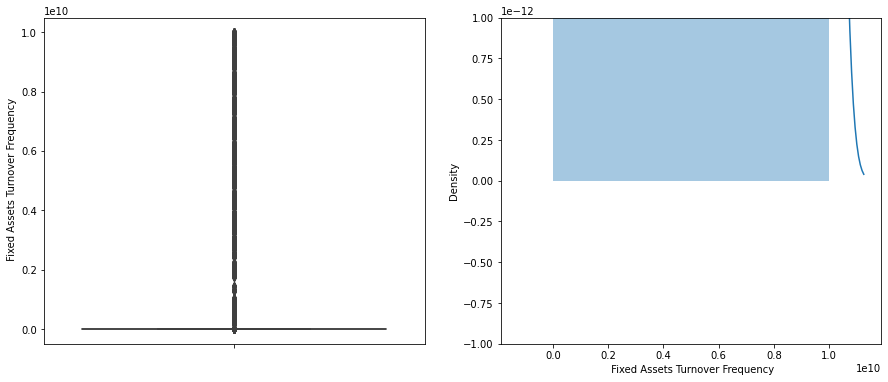

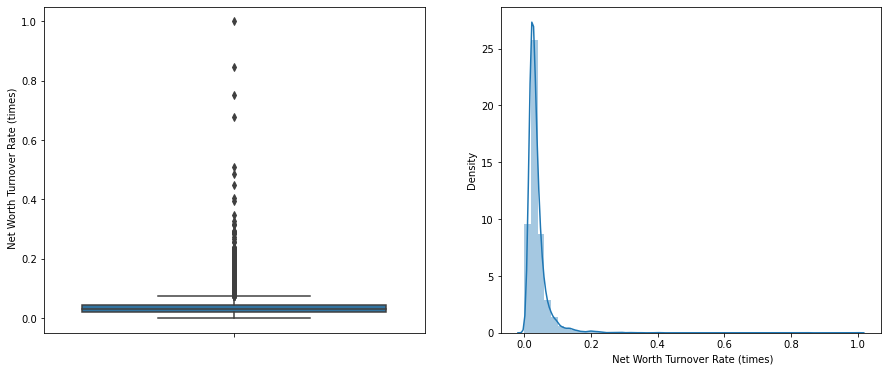

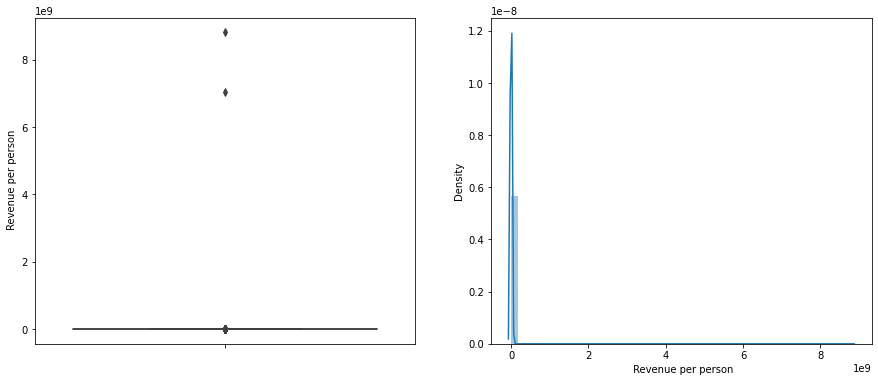

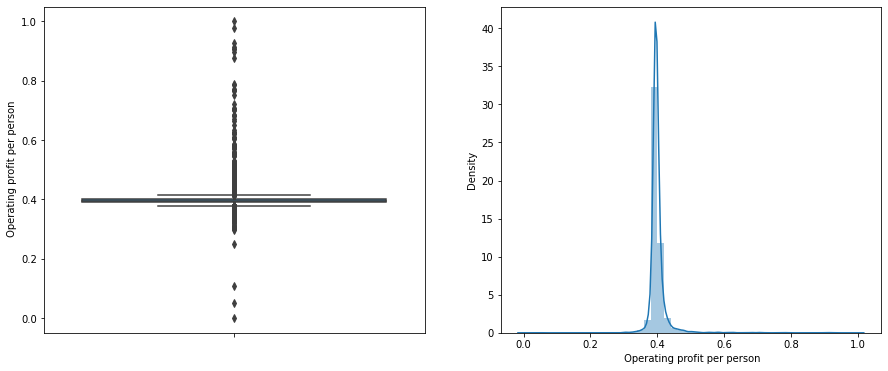

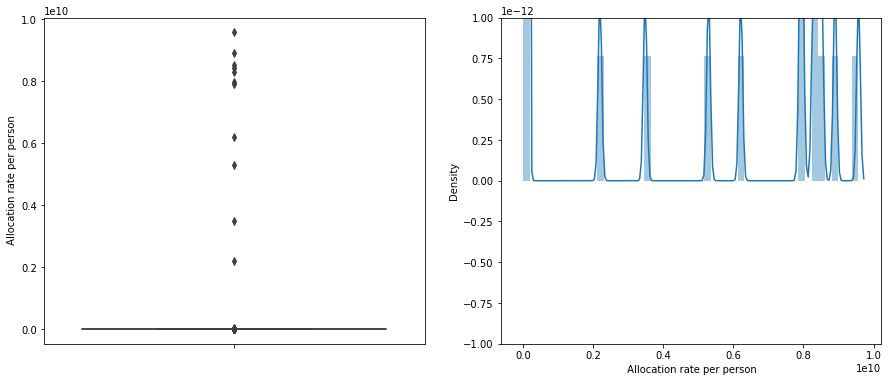

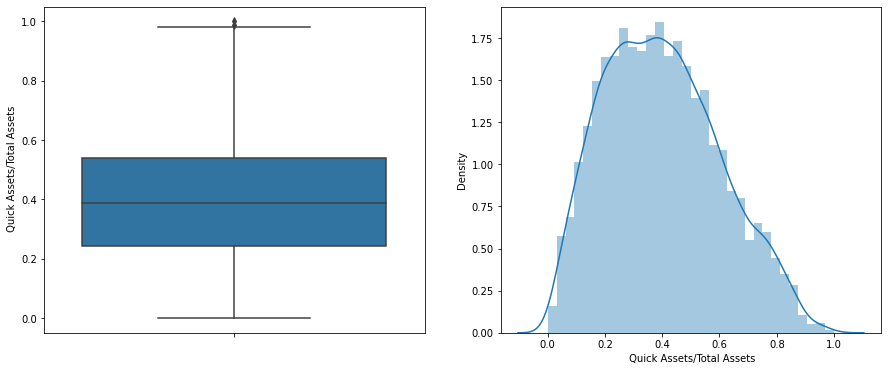

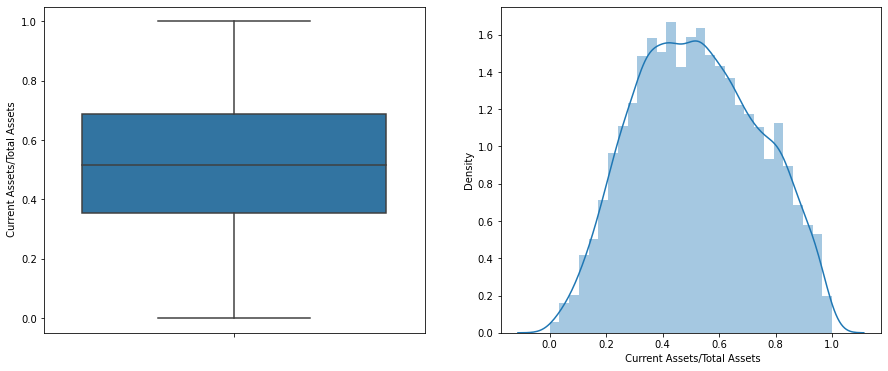

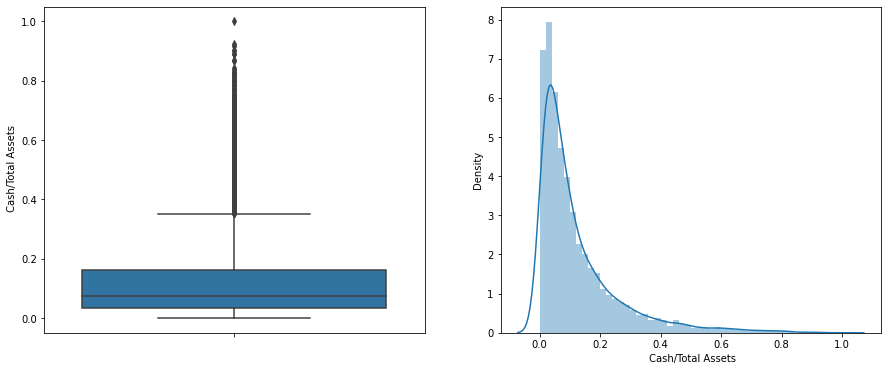

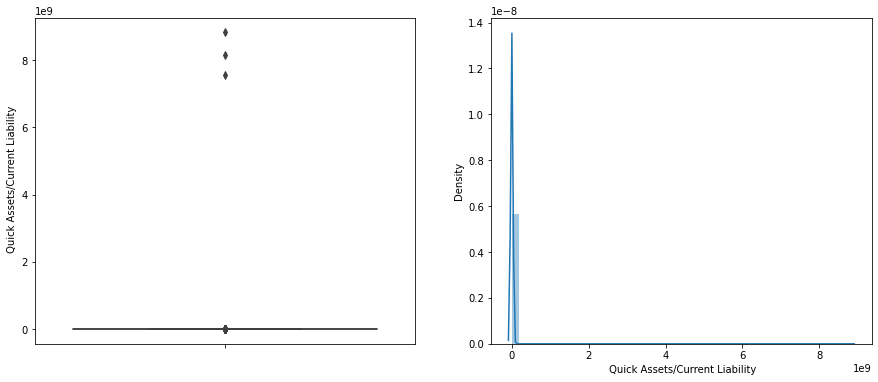

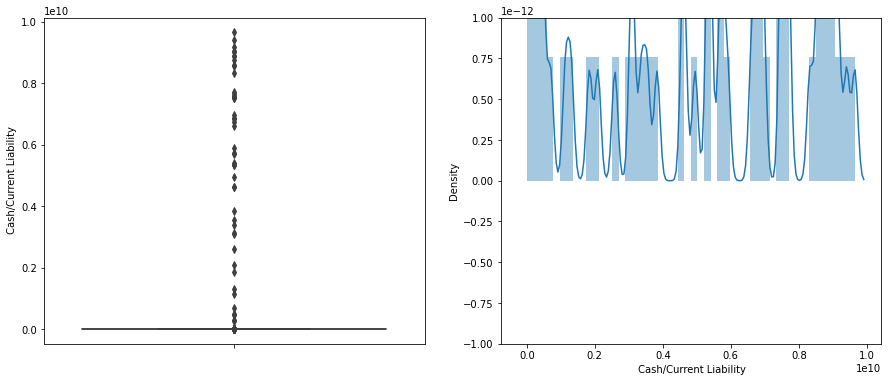

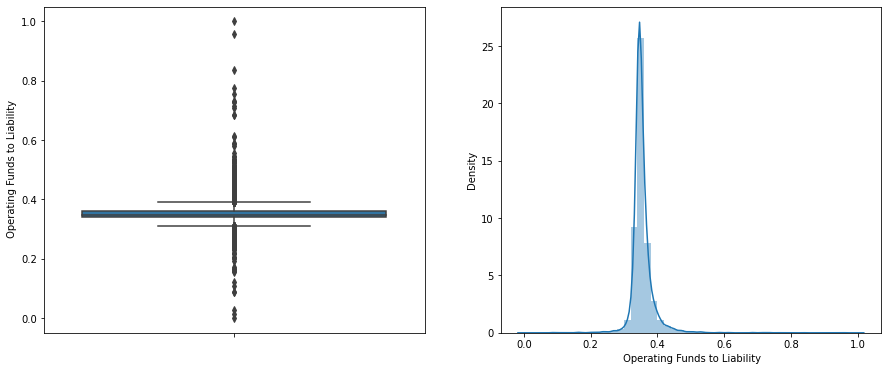

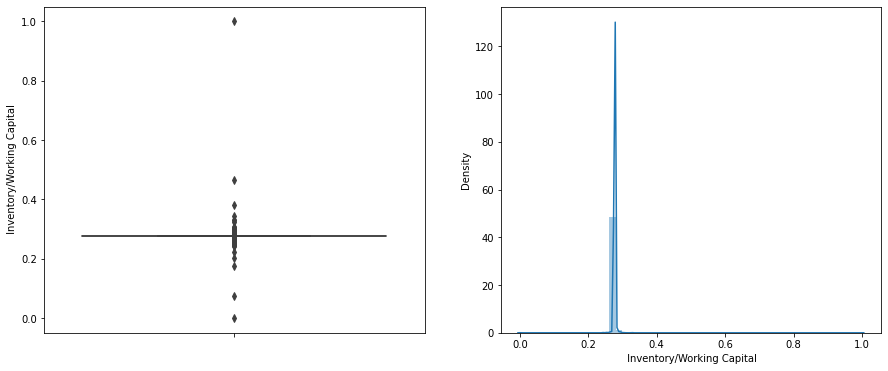

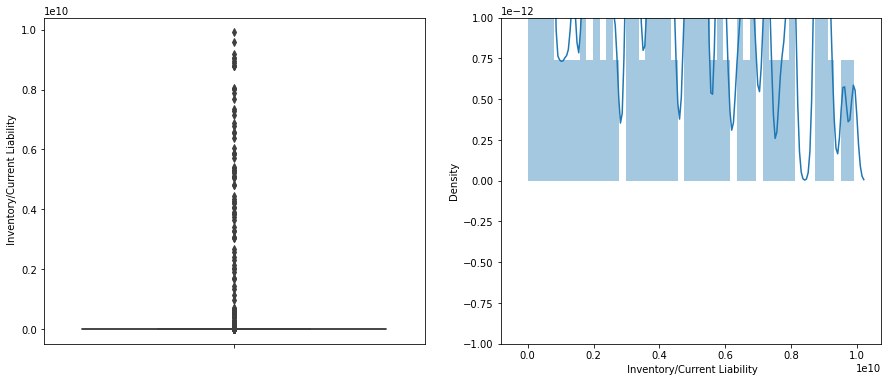

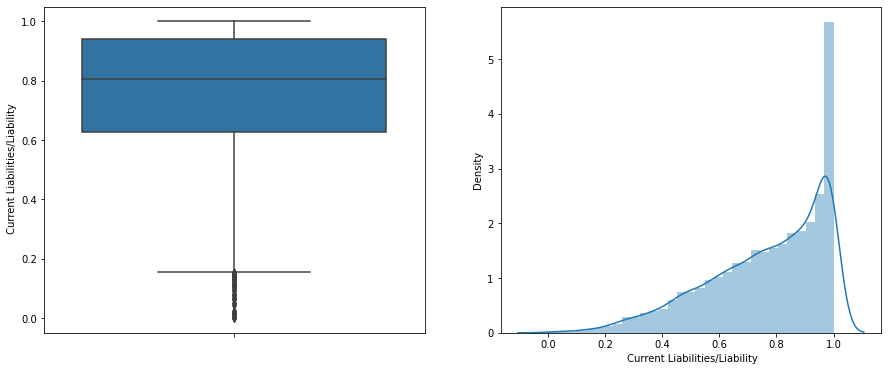

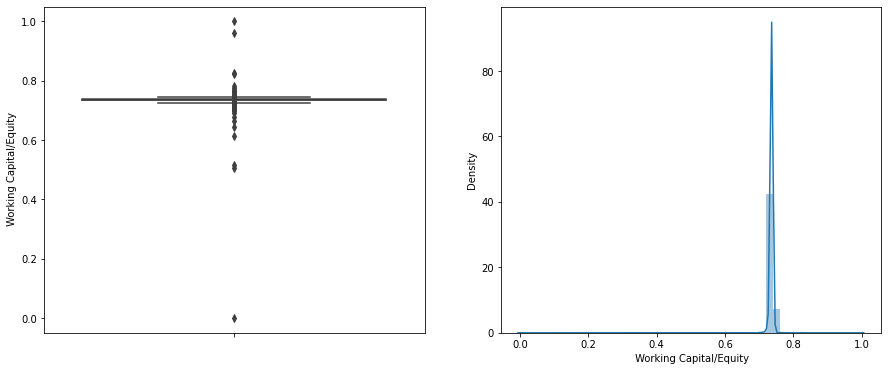

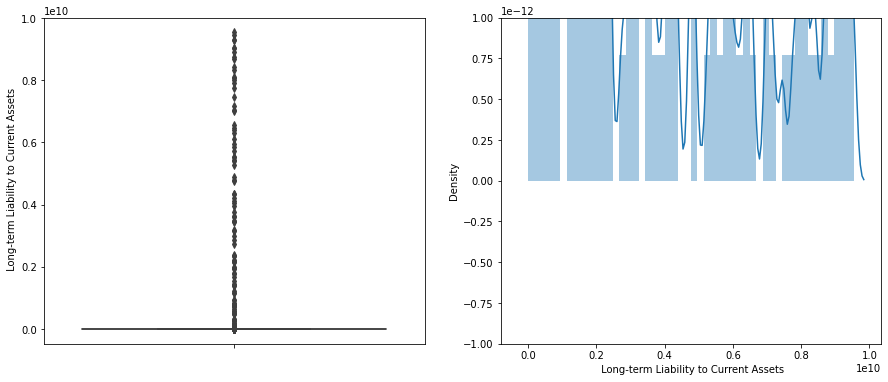

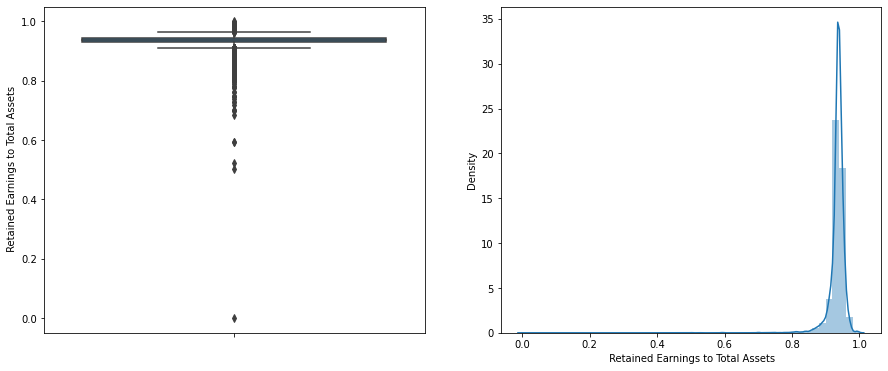

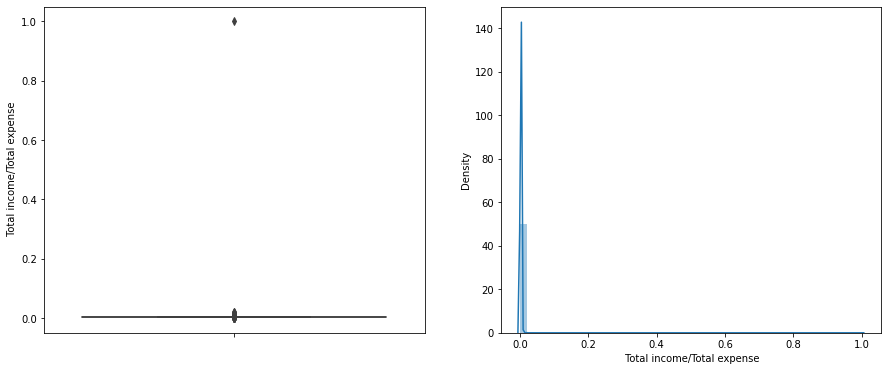

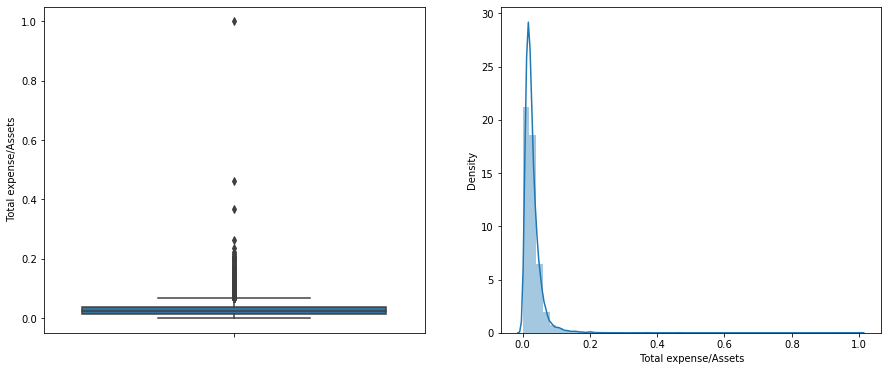

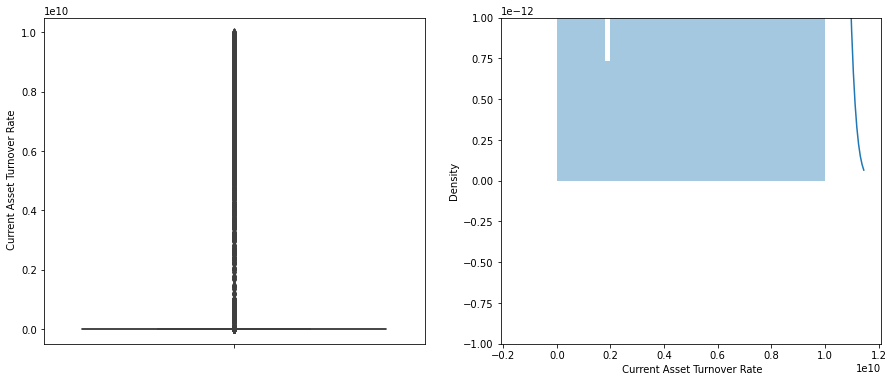

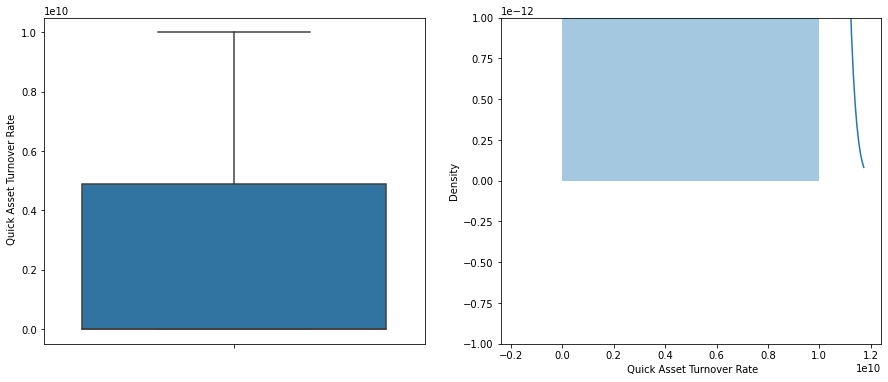

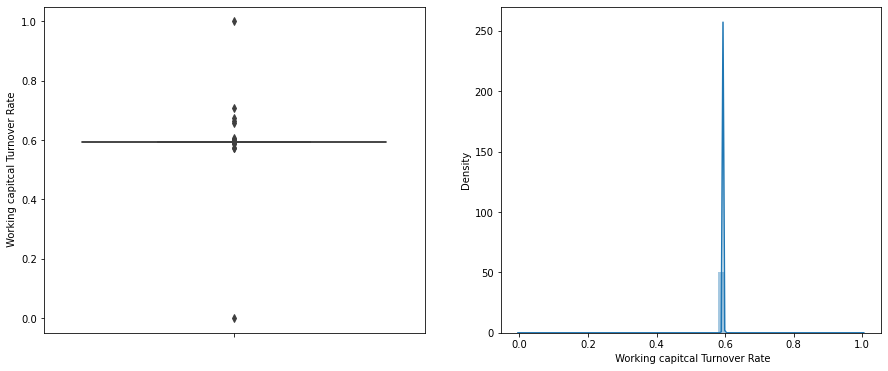

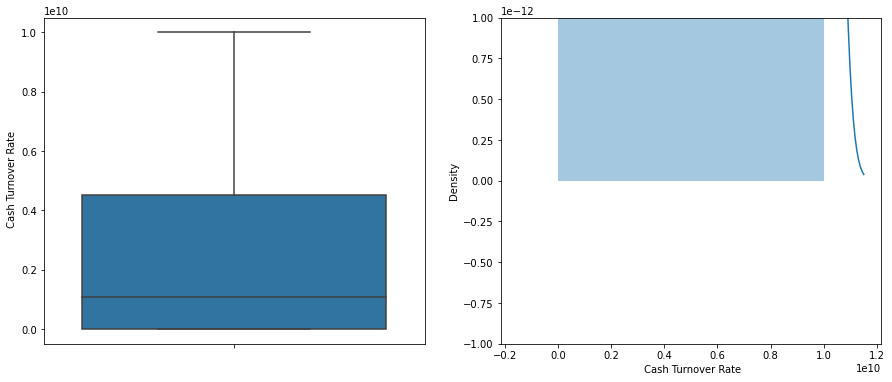

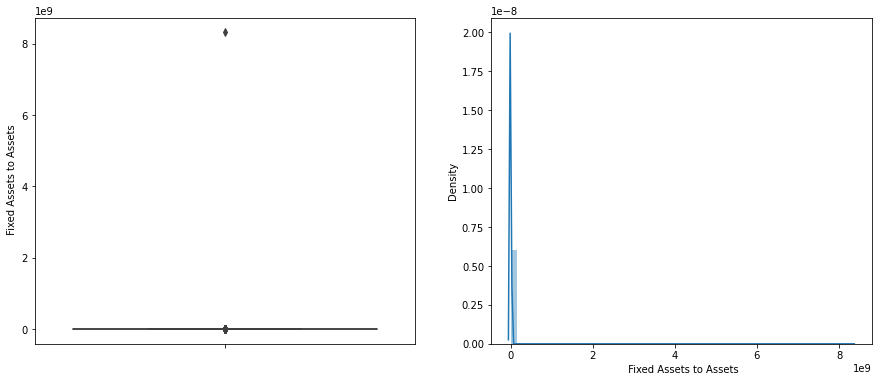

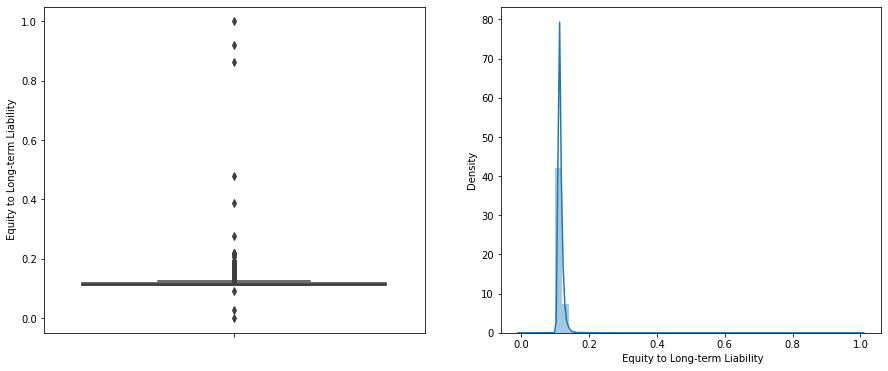

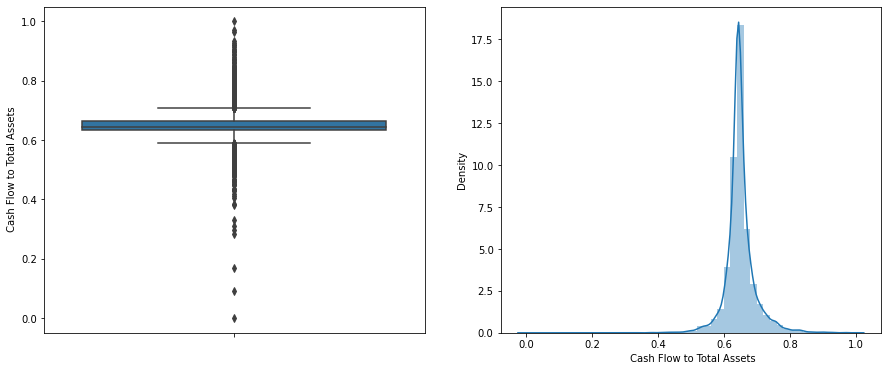

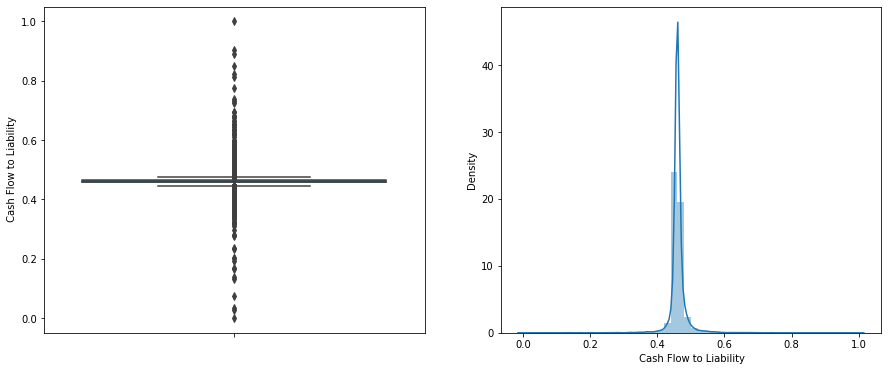

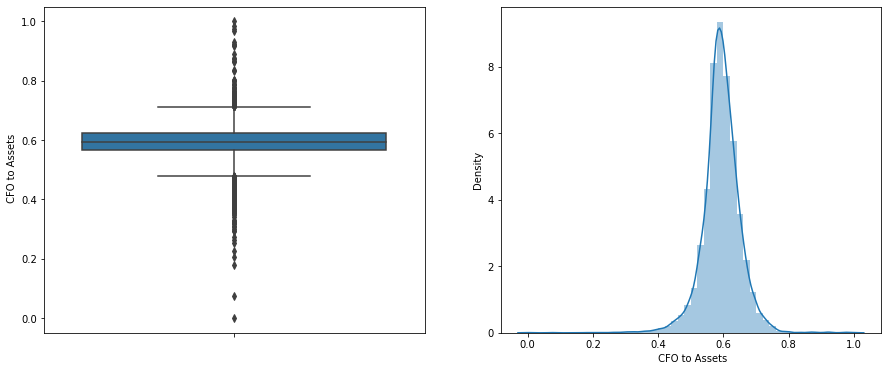

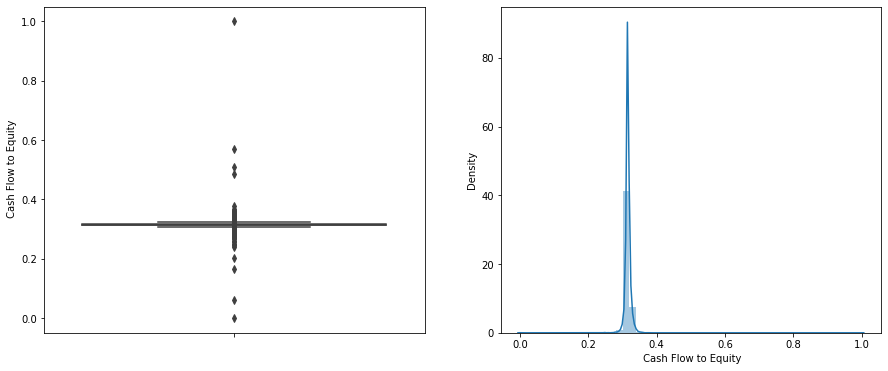

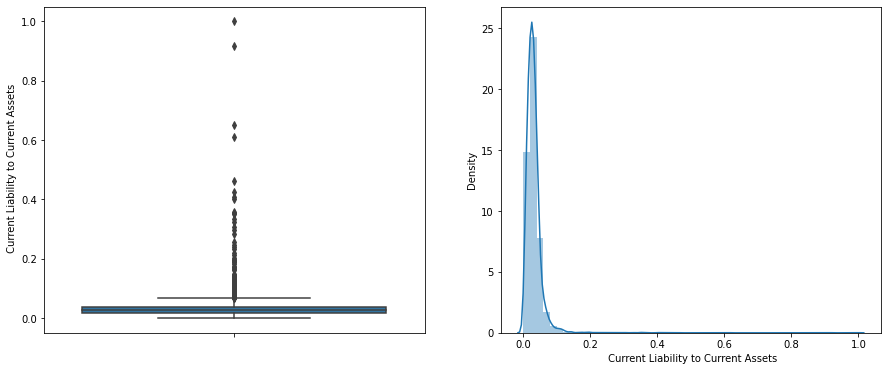

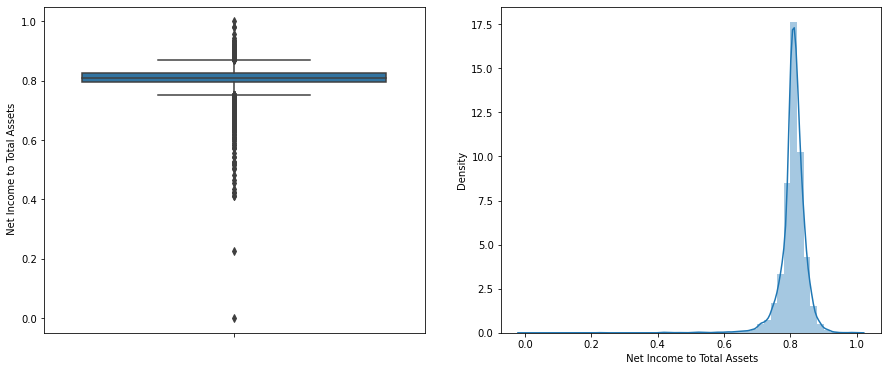

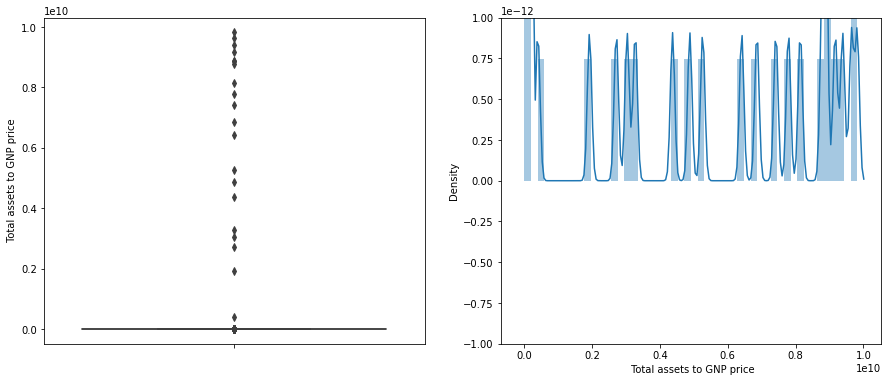

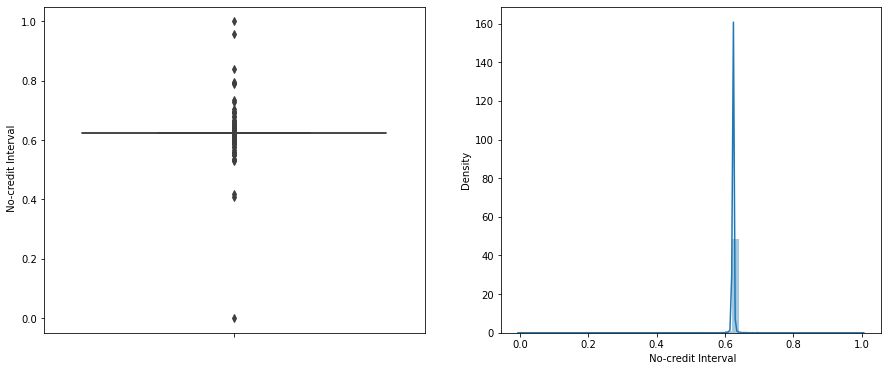

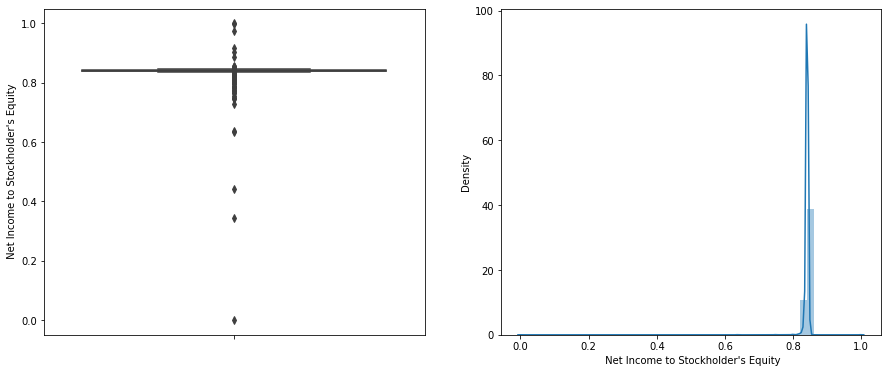

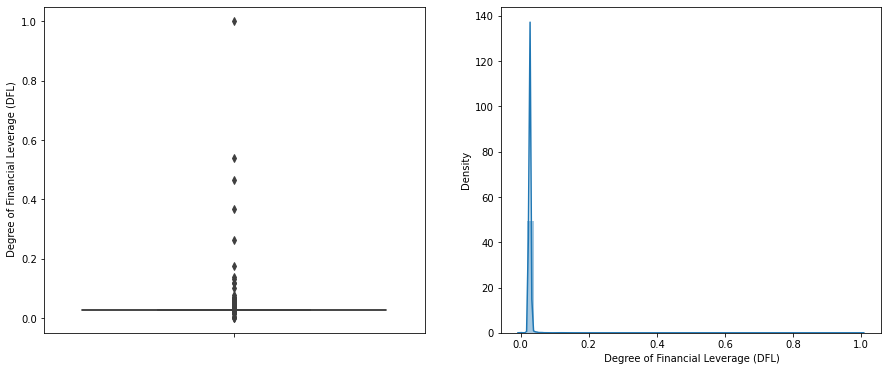

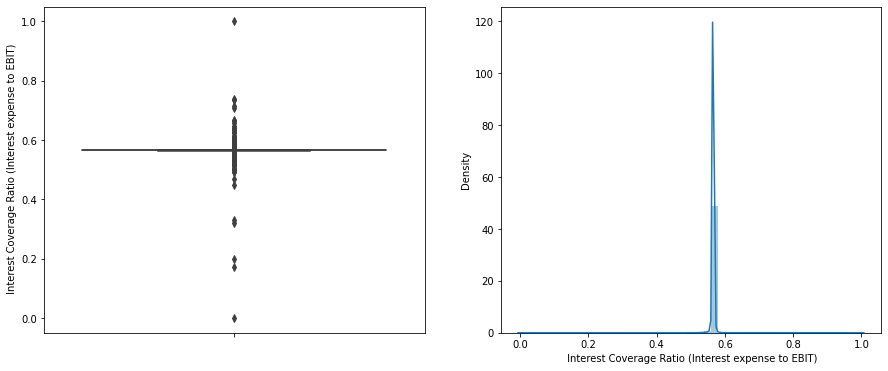

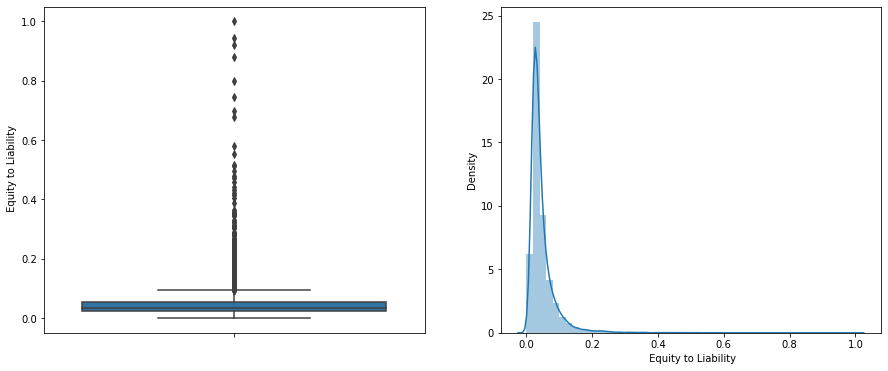

In [52]:
def plotter():
  for var in columns_after_vif :
      plt.figure(figsize=(15,6))
      plt.subplot(1, 2, 1)
      fig = sns.boxplot(y=df[var])
      fig.set_title('')
      fig.set_ylabel(var)
      
      plt.subplot(1, 2, 2)
      fig = sns.distplot(df[var].dropna())
      fig.set_xlabel(var)

      plt.show()

plotter()